## Step 3 - Climate Analysis and Exploration

You are now ready to use Python and SQLAlchemy to do basic climate analysis and data exploration on your new weather station tables. All of the following analysis should be completed using SQLAlchemy ORM queries, Pandas, and Matplotlib.

* Create a Jupyter Notebook file called `climate_analysis.ipynb` and use it to complete your climate analysis and data exporation.

* Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

* Use SQLAlchemy `create_engine` to connect to your sqlite database.

* Use SQLAlchemy `automap_base()` to reflect your tables into classes and save a reference to those classes called `Station` and `Measurement`.

In [131]:
# Import Dependencies
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine

In [161]:
# Create an engine for the hawaii.sqlite database
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [162]:
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [134]:
Base.classes.items()

[('measurements', sqlalchemy.ext.automap.measurements),
 ('stations', sqlalchemy.ext.automap.stations)]

In [135]:
# Save a reference to the stations table as `Station`
Station = Base.classes.stations

In [136]:
# Save a reference to the measurements table as `Measurement`
Measurement = Base.classes.measurements

### Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame and set the index to the date column.

* Plot the results using the DataFrame `plot` method.

<center><img src='images/precip.png' /></center>

* Use Pandas to print the summary statistics for the precipitation data.

In [137]:
# Create a database session object
from sqlalchemy.orm import Session
session = Session(engine)

In [138]:
# calculate the begin-date(using sqlalchemy) and end-date(using python object) to construct a 12 month time-window 
# in order to extract data for the past 12 months
from datetime import datetime
from datetime import timedelta
year = timedelta(days=365)

# get the latest date using the measurment table
end_date = session.query(Measurement.date,Measurement.prcp).order_by(Measurement.date.desc())[1][0]
# calulate the begin date
begin_date = end_date - year

In [139]:
from sqlalchemy import func
from sqlalchemy.sql import label
result_proxy = session.query(Measurement.date,label('prcp',func.avg(Measurement.prcp))).\
                filter(Measurement.date>=begin_date).\
                group_by(Measurement.date)

In [140]:
# instantitate an empty list called data to store the result proxy
data = []
for row in result_proxy:
    data.append({'date': row[0], 'prcp': row[1]})

In [141]:
# convert the result proxy to a pandas dataframe
import pandas as pd
df_prec = pd.DataFrame(data)
display(df_prec.head())
display(df_prec.shape)

,date,prcp
0,2016-08-23,0.451667
1,2016-08-24,1.555000
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.064000


(366, 2)

In [142]:
# set the index to date
df_prec = df_prec.set_index('date',drop=True)
display(df_prec.head())
display(df_prec.shape)

,prcp
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000


(366, 1)

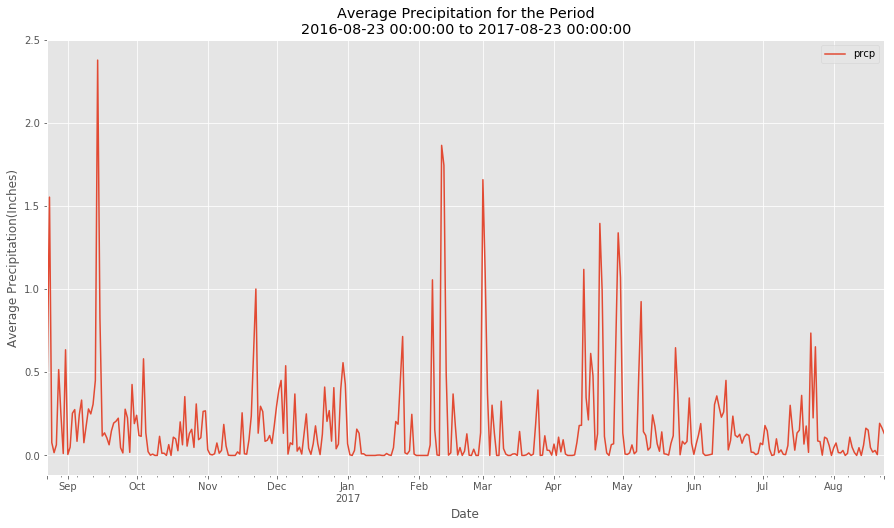

In [143]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
_ = df_prec.plot(figsize=(15,8))
_ = plt.xlabel('Date')
_ = plt.ylabel('Average Precipitation(Inches)')
_ = plt.title("Average Precipitation for the Period"+"\n"+"{} to {}".format(begin_date,end_date))
plt.show()

In [144]:
df_prec.describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,366.0,0.170757,0.295683,0.0,0.008571,0.07,0.191667,2.38


### Station Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order

  * Which station has the highest number of observations?

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.

  <center><img src='images/temp_hist.png' height="400px" /></center>

In [145]:
# Design a query to calculate the total number of stations.
from sqlalchemy import distinct
number_of_stations = session.query(func.count(distinct(Measurement.station))).scalar()
print(f'The total number of stations : {number_of_stations}')

The total number of stations : 9


In [146]:
result_proxy = session.query(Measurement,Station,label('number_of_observations',func.count(Station.station))).\
                     join(Station).\
                     group_by(Station.station).\
                     order_by(func.count(Station.station).desc()).\
                     all()
data =[]      

for row in result_proxy:
    data.append({'station':row.stations.name,'number_of_observations':row.number_of_observations})

In [147]:
df = pd.DataFrame(data)
df= df[['station','number_of_observations']]
df.style.bar(subset=['number_of_observations'], align='mid', color=['#d65f5f'])

,station,number_of_observations
0,"WAIHEE 837.5, HI US",2772
1,"KANEOHE 838.1, HI US",2696
2,"WAIKIKI 717.2, HI US",2685
3,"WAIMANALO EXPERIMENTAL FARM, HI US",2572
4,"MANOA LYON ARBO 785.2, HI US",2484
5,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1937
6,"HONOLULU OBSERVATORY 702.2, HI US",1932
7,"PEARL CITY, HI US",683
8,"UPPER WAHIAWA 874.3, HI US",342


In [148]:
# Which station has the highest number of observations?
result_proxy = session.query(Measurement,Station,label('number_of_observations',func.count(Station.station))).\
                     join(Station).\
                     group_by(Station.station).\
                     order_by(func.count(Station.station).desc()).\
                     first()
    
most_active_station = result_proxy.stations.name
print(f'Station which has the highest number of observations : {most_active_station}')

Station which has the highest number of observations : WAIHEE 837.5, HI US


In [149]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
# Plot the results as a histogram with bins=12.
from sqlalchemy import func
from sqlalchemy.sql import label

result_proxy = session.query(Measurement,label('tobs',func.avg(Measurement.tobs))).\
                join(Station).\
                filter(Measurement.date>=begin_date).\
                filter(Station.name==most_active_station).\
                group_by(Measurement.date).all()

In [150]:
# instantitate an empty list called data to store the result proxy
data = []
for row in result_proxy:
    data.append({'date': row.measurements.date, 'tobs': row.measurements.tobs})

In [151]:
# convert the result proxy to a pandas dataframe
df_tobs = pd.DataFrame(data)
display(df_tobs.head())
display(df_tobs.info())

,date,tobs
0,2016-08-23,77
1,2016-08-24,77
2,2016-08-25,80
3,2016-08-26,80
4,2016-08-27,75


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352 entries, 0 to 351
Data columns (total 2 columns):
date    352 non-null datetime64[ns]
tobs    352 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.6 KB


None

In [152]:
# set the index to date
df_tobs.set_index('date',drop=True,inplace=True)

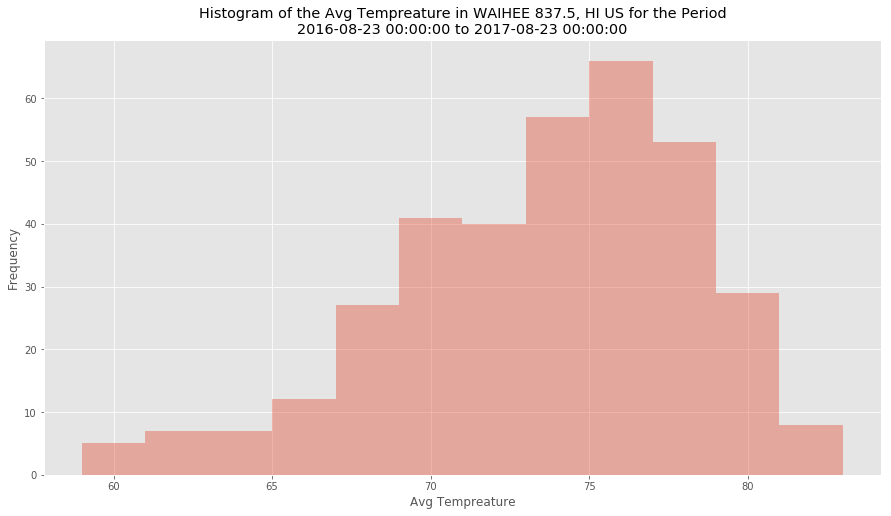

In [153]:
import seaborn as sns
plt.figure(figsize=(15,8))
_ = sns.distplot(df_tobs,bins=12,kde=False)
_ = plt.xlabel('Avg Tempreature')
_ = plt.ylabel('Frequency')
_ = plt.title("Histogram of the Avg Tempreature in {} for the Period".format(most_active_station)+"\n"+"{} to {}".format(begin_date,end_date))
plt.show();

### Temperature Analysis

* Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

<center><img src='images/temp_avg.png'/></center>

In [154]:
from datetime import date
from sqlalchemy import and_

def calc_temps():
    '''the function will accept a start date and end date in the format %Y-%m-%d
    and return the minimum, average, and maximum temperatures for that range of dates and a plot to
    visualize the information'''
    
    date_entry = input('Enter the start date in YYYY-MM-DD format ')
    year, month, day = map(int, date_entry.split('-')) # map(function_to_apply, list_of_inputs)
    begin_date = date(year-1, month, day) # calculate the matching begin date from the previous year
    date_entry = input('Enter the end date in YYYY-MM-DD format ')
    year, month, day = map(int, date_entry.split('-'))
    end_date = date(year-1, month, day) # calculate the matching end date from the previous year
  
    result_proxy = session.query(Measurement.tobs).\
                    filter(and_(Measurement.date >=begin_date, Measurement.date <=end_date))

    data = []
    for result in result_proxy:
        data.append(result)

    df = pd.DataFrame(data)
    temp = dict({'min':df.min()[0],'max':df.max()[0],'mean':df.mean()[0]})
    avg = temp['mean']
    error = temp['max']-temp['min']
    
    plt.figure(figsize=(3,10))
    _ = plt.bar(left=1,height=avg, align='center', yerr = error)
    _ = plt.ylabel('Temp(F)')
    _ = plt.title('Trip Avg Temp')
    plt.axes().get_xaxis().set_visible(False)
    plt.show();  

Enter the start date in YYYY-MM-DD format 2018-03-10
Enter the end date in YYYY-MM-DD format 2018-03-20


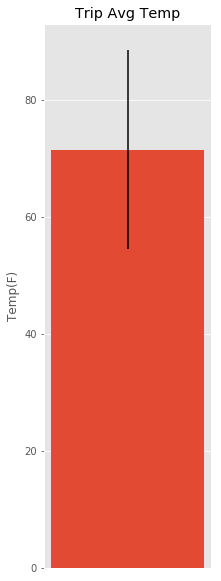

In [155]:
calc_temps()

### Optional Recommended Analysis

* The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.

  * Calcualte the rainfall per weather station using the previous year's matching dates.

* Calculate the daily normals. Normals are the averages for min, avg, and max temperatures.

  * Create a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic tobs that match that date string.

  * Create a list of dates for your trip in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

  * Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.

  * Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

  <center><img src="images/daily_normals.png" /></center>

In [156]:
# Calcualte the rainfall per weather station using the previous year's matching dates.
def dates_previous_year():
    
    '''the function will accept a start date and end date in the format %Y-%m-%d
    and returns the previous year's matching dates'''
        
    date_entry = input('Enter the start date in YYYY-MM-DD format ')
    year, month, day = map(int, date_entry.split('-')) # map(function_to_apply, list_of_inputs)
    begin_date = date(year-1, month, day) # calculate the matching begin date from the previous year
    date_entry = input('Enter the end date in YYYY-MM-DD format ')
    year, month, day = map(int, date_entry.split('-'))
    end_date = date(year-1, month, day) # calculate the matching end date from the previous year
  
    return dict({'start':begin_date,'end':end_date})

In [157]:
# get the previous year's matching dates
matching_dates = dates_previous_year()
start = matching_dates['start']
end = matching_dates['end']

Enter the start date in YYYY-MM-DD format 2018-05-10
Enter the end date in YYYY-MM-DD format 2018-05-15


In [158]:
# query the the rainfall per weather station using the previous year's matching dates.
result_proxy = session.query(Measurement,Station,Station.name,label('rainfall',func.avg(Measurement.prcp))).\
               join(Station).\
               filter(and_(Measurement.date >=start, Measurement.date <=end)).\
               group_by(Station.name).all()

In [159]:
# create an empty list to store the query results
data =[]      
for row in result_proxy:
    data.append({'station':row.stations.name,'RainFall':row.rainfall})

In [160]:
# covert the query results to a pandas dataframe
df = pd.DataFrame(data)
df= df[['station','RainFall']]
df.style.bar(subset=['RainFall'], align='mid', color=['#5fba7d'])

,station,RainFall
0,"KANEOHE 838.1, HI US",0.038
1,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0
2,"MANOA LYON ARBO 785.2, HI US",0.438
3,"WAIHEE 837.5, HI US",0.126
4,"WAIKIKI 717.2, HI US",0.002
5,"WAIMANALO EXPERIMENTAL FARM, HI US",0.012


In [6]:
from datetime import date
startdate ='2017-01-15'
year,month,day = map(int,startdate.split('-'))
date(year,month,day)

datetime.date(2017, 1, 15)